In [126]:
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display
%matplotlib inline



In [162]:
df = pd.read_csv('./data/immo_data.csv')
df.head()

,regio1,serviceCharge,heatingType,telekomTvOffer,telekomHybridUploadSpeed,newlyConst,balcony,picturecount,pricetrend,telekomUploadSpeed,...,regio2,regio3,description,facilities,heatingCosts,energyEfficiencyClass,lastRefurbish,electricityBasePrice,electricityKwhPrice,date
0,Nordrhein_Westfalen,245.00,central_heating,ONE_YEAR_FREE,NaN,False,False,6,4.62,10.0,...,Dortmund,Schüren,Die ebenerdig zu erreichende Erdgeschosswohnun...,Die Wohnung ist mit Laminat ausgelegt. Das Bad...,NaN,NaN,NaN,NaN,NaN,May19
1,Rheinland_Pfalz,134.00,self_contained_central_heating,ONE_YEAR_FREE,NaN,False,True,8,3.47,10.0,...,Rhein_Pfalz_Kreis,Böhl_Iggelheim,Alles neu macht der Mai – so kann es auch für ...,NaN,NaN,NaN,2019.0,NaN,NaN,May19
2,Sachsen,255.00,floor_heating,ONE_YEAR_FREE,10.0,True,True,8,2.72,2.4,...,Dresden,Äußere_Neustadt_Antonstadt,Der Neubau entsteht im Herzen der Dresdner Neu...,"* 9 m² Balkon\n* Bad mit bodengleicher Dusche,...",NaN,NaN,NaN,NaN,NaN,Oct19
3,Sachsen,58.15,district_heating,ONE_YEAR_FREE,NaN,False,True,9,1.53,40.0,...,Mittelsachsen_Kreis,Freiberg,Abseits von Lärm und Abgasen in Ihre neue Wohn...,NaN,87.23,NaN,NaN,NaN,NaN,May19
4,Bremen,138.00,self_contained_central_heating,NaN,NaN,False,True,19,2.46,NaN,...,Bremen,Neu_Schwachhausen,Es handelt sich hier um ein saniertes Mehrfami...,Diese Wohnung wurde neu saniert und ist wie fo...,NaN,NaN,NaN,NaN,NaN,Feb20


### Define columns of interest

In [163]:
object_columns = ['regio1', 'regio2', 'firingTypes', 'condition',
           'interiorQual', 'typeOfFlat', 'energyEfficiencyClass' ]

float_int_columns = ['serviceCharge', 'totalRent', 'yearConstructed', 'baseRent',
                     'livingSpace', 'noRooms', 'thermalChar', 'floor', 'heatingCosts',
                     'lastRefurbish']
bool_columns = ['balcony', 'hasKitchen', 'cellar', 'lift', 'garden' ]

### Remove rows woth nan values for totalRent and livingSpace columns

In [228]:
cleaned = df.dropna(subset=['totalRent', 'livingSpace'])

### Remove livingSpace which is zero

In [229]:
cleaned = cleaned[cleaned.livingSpace != 0.]

# Useful functions


In [230]:

def add_iqr(describe):
    '''
    INPUT:
    df_describe - dataframe from df.describe()

    OUTPUT:
    new_df_describe - a dataframe with added IQR to index
    
    calculates the IQR with 75% - 25% quantile
    '''
    describe.loc['IQR'] = describe.loc['75%'] - describe.loc['25%']
    
    return describe




In [231]:
def remove_outlier(df, columns):
    '''
    INPUT:
    df - the pandas dataframe you want to remove outliers
    columns - the columns you want to remove outliers, dtype=list

    OUTPUT:
    new_df - a dataframe with removed outliers for specified columns
    '''
    describe = add_iqr(df.describe())
    index = df.index
    for col in columns:
        iqr = describe.loc['IQR', col]
        lower = describe.loc['25%', col]
        upper = describe.loc['75%', col]
        new_index = df[df[col].between(lower - 1.5*iqr, upper + 1.5*iqr)].index
        index=np.intersect1d(index, new_index)
        
    return df[df.index.isin(index)]

### Draw Statistics to totalRent, livingSpace, Squaremeterprice

In [232]:
cleaned = remove_outlier(df, ['totalRent', 'livingSpace'])

In [233]:
cleaned.loc[:, ['totalRent', 'livingSpace']].describe()

,totalRent,livingSpace
count,212250.000000,212250.000000
mean,709.857452,67.658629
std,334.430005,23.092435
min,0.000000,5.500000
25%,458.462500,52.500000
50%,615.000000,65.000000
75%,895.000000,81.000000
max,1757.530000,136.500000


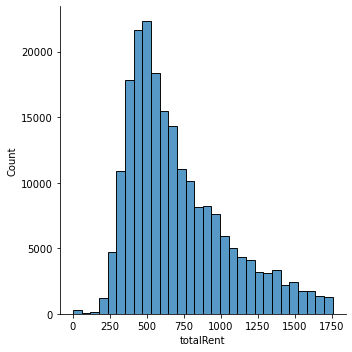

In [234]:
sns.displot(data=cleaned, x='totalRent', bins=30)

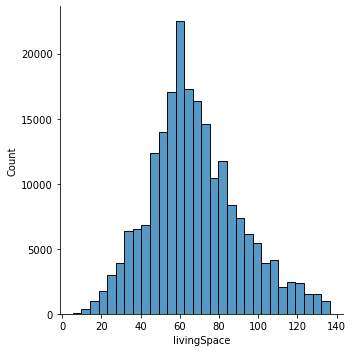

In [235]:
sns.displot(data=cleaned, x='livingSpace', bins=30)

#### Calculate Price per square meter

In [236]:
cleaned.loc[:,'squaremeterprice'] = cleaned['totalRent'] / cleaned['livingSpace']
cleaned = remove_outlier(cleaned, ['squaremeterprice'])

/Users/florian/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/florian/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


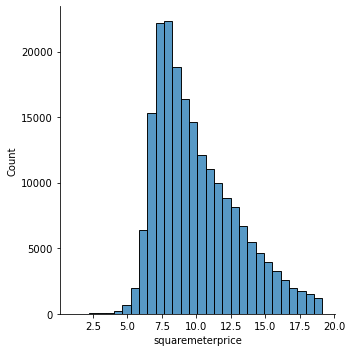

In [237]:
sns.displot(data=cleaned, x='squaremeterprice', bins=30)

### Create Price over time table

Create a table 

In [238]:

price_over_time = cleaned.groupby(['date', 'regio2']).squaremeterprice.mean().reset_index(name='Mean_Squaremeterprice').pivot(index='regio2', columns='date', values='Mean_Squaremeterprice')

In [239]:
price_over_time = price_over_time.dropna()
price_over_time = price_over_time[['Sep18', 'May19', 'Oct19', 'Feb20']]

In [240]:
price_over_time.head()

date,Sep18,May19,Oct19,Feb20
regio2,,,,
Aachen,11.949394,12.124795,12.055116,12.136585
Aachen_Kreis,9.820544,10.033893,9.756573,10.043100
Ahrweiler_Kreis,9.557576,9.499012,10.089386,10.538145
Aichach_Friedberg_Kreis,12.299791,12.106054,12.307967,12.434551
Alb_Donau_Kreis,10.254021,10.733930,10.856839,11.475499


In [241]:
region = 'München'
for value in price_over_time.index:
    if region in value:
        print(value)

München
München_Kreis


In [242]:
dates = price_over_time.columns[:-1]
dates

price_over_time.loc[:, 'change_18_19'] = price_over_time['Oct19'] / price_over_time['Sep18'] * 100 - 100
price_over_time.loc[:, 'change_19_19'] = price_over_time['May19'] / price_over_time['Oct19'] * 100 - 100
price_over_time.loc[:, 'change_19_20'] = price_over_time['Oct19'] / price_over_time['Feb20'] * 100 - 100

In [243]:
price_over_time

date,Sep18,May19,Oct19,Feb20,change_18_19,change_19_19,change_19_20
regio2,,,,,,,
Aachen,11.949394,12.124795,12.055116,12.136585,0.884753,0.578003,-0.671262
Aachen_Kreis,9.820544,10.033893,9.756573,10.043100,-0.651395,2.842390,-2.852972
Ahrweiler_Kreis,9.557576,9.499012,10.089386,10.538145,5.564279,-5.851438,-4.258425
Aichach_Friedberg_Kreis,12.299791,12.106054,12.307967,12.434551,0.066474,-1.640509,-1.017997
Alb_Donau_Kreis,10.254021,10.733930,10.856839,11.475499,5.878845,-1.132081,-5.391145
...,...,...,...,...,...,...,...
Würzburg_Kreis,11.027261,11.441814,11.247416,11.491910,1.996464,1.728377,-2.127530
Zollernalbkreis,11.446345,9.896757,10.331396,10.634591,-9.740655,-4.206966,-2.851027
Zweibrücken,7.688038,8.723632,7.676068,9.218884,-0.155688,13.647136,-16.735383


In [244]:
price_over_time_melt = price_over_time.melt(id_vars=['Sep18', 'May19', 'Oct19', 'Feb20'])


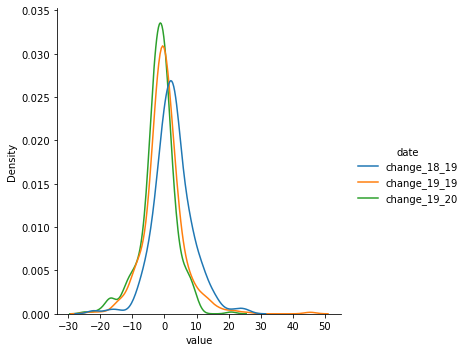

In [245]:
sns.displot(data=price_over_time_melt, x='value', hue='date', kind='kde')

In [246]:
cleaned = cleaned.loc[:, object_columns + float_int_columns + bool_columns + ['squaremeterprice']]
cleaned

,regio1,regio2,firingTypes,condition,interiorQual,typeOfFlat,energyEfficiencyClass,serviceCharge,totalRent,yearConstructed,...,thermalChar,floor,heatingCosts,lastRefurbish,balcony,hasKitchen,cellar,lift,garden,squaremeterprice
0,Nordrhein_Westfalen,Dortmund,oil,well_kept,normal,ground_floor,NaN,245.0,840.00,1965.0,...,181.40,1.0,NaN,1965.0,False,False,True,False,True,9.767442
2,Sachsen,Dresden,NaN,first_time_use,sophisticated,apartment,NaN,255.0,1300.00,2019.0,...,NaN,3.0,NaN,2019.0,True,False,True,True,False,15.513126
4,Bremen,Bremen,gas,refurbished,NaN,apartment,NaN,138.0,903.00,1950.0,...,188.90,1.0,NaN,1950.0,True,False,False,False,False,10.627280
6,Sachsen,Mittelsachsen_Kreis,NaN,fully_renovated,NaN,NaN,NaN,70.0,380.00,0.0,...,NaN,1.0,NaN,0.0,False,False,True,False,True,6.129032
7,Bremen,Bremen,gas:electricity,NaN,NaN,ground_floor,B,88.0,584.25,1959.0,...,63.00,NaN,44.0,1959.0,True,False,True,False,False,9.689055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268844,Nordrhein_Westfalen,Essen,gas,first_time_use_after_refurbishment,sophisticated,roof_storey,NaN,80.0,670.00,0.0,...,NaN,3.0,NaN,2019.0,False,False,False,False,False,7.882353
268845,Bayern,Weilheim_Schongau_Kreis,geothermal,mint_condition,sophisticated,roof_storey,NaN,90.0,910.00,2016.0,...,NaN,NaN,NaN,2016.0,True,False,True,False,False,10.111111
268846,Hessen,Bergstraße_Kreis,gas,well_kept,sophisticated,apartment,NaN,220.0,1150.00,1983.0,...,NaN,1.0,NaN,2015.0,True,True,False,False,False,10.000000
268847,Hessen,Limburg_Weilburg_Kreis,gas,well_kept,NaN,apartment,NaN,220.0,930.00,1965.0,...,160.77,1.0,NaN,2019.0,True,False,True,False,True,9.789474


### Get Dummies for Firing Types

The firing types are strings. it is possible that more thean one firing type is give, seperated by :
Split the strings into list objects and use a MultiLabelBinarizer to create a one hot encoding.




In [247]:
# One hot encoding channels
from sklearn.preprocessing import MultiLabelBinarizer

# Fill the nan values in firing Type with string to make it fit for MLB
cleaned.firingTypes = cleaned.firingTypes.fillna('Unknown_firingType')
cleaned['firingTypes_mod'] = cleaned.firingTypes.str.split(':')



mlb = MultiLabelBinarizer(sparse_output=True)

cleaned = cleaned.join(
            pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(cleaned.pop('firingTypes_mod')),
                index=cleaned.index,
                columns=mlb.classes_))



In [255]:
possible_vals = set()

cleaned.firingTypes = cleaned.firingTypes.str.replace(r': ', ':')
for list_ in cleaned.firingTypes.str.split(':').dropna():
    for value in list_:
        possible_vals.add(value)
possible_vals = list(possible_vals)
possible_vals

['heat_supply',
 'gas',
 'geothermal',
 'pellet_heating',
 'electricity',
 'combined_heat_and_power_renewable_energy',
 'bio_energy',
 'district_heating',
 'combined_heat_and_power_regenerative_energy',
 'wood',
 'wood_chips',
 'natural_gas_light',
 'combined_heat_and_power_fossil_fuels',
 'natural_gas_heavy',
 'liquid_gas',
 'solar_heating',
 'local_heating',
 'Unknown_firingType',
 'wind_energy',
 'combined_heat_and_power_bio_energy',
 'hydro_energy',
 'coal_coke',
 'oil',
 'coal',
 'environmental_thermal_energy',
 'steam_district_heating']

In [256]:
cleaned.firingTypes.value_counts()

gas                                                84809
Unknown_firingType                                 41381
district_heating                                   37237
oil                                                13591
natural_gas_light                                   8008
                                                   ...  
geothermal:solar_heating:pellet_heating                1
gas:oil:electricity                                    1
district_heating:natural_gas_heavy                     1
geothermal:electricity                                 1
solar_heating:wood:environmental_thermal_energy        1
Name: firingTypes, Length: 107, dtype: int64

In [257]:
def total_count(df, col1, col2, look_for):
    '''
    INPUT:
    df - the pandas dataframe you want to search
    col1 - the column name you want to look through
    col2 - the column you want to count values from
    look_for - a list of strings you want to search for in each row of df[col]

    OUTPUT:
    new_df - a dataframe of each look_for with the count of how often it shows up
    '''
    new_df = defaultdict(int)
    #loop through list of ed types
    for val in look_for:
        #loop through rows
        for idx in range(df.shape[0]):
            #if the ed type is in the row add 1
            if val in df[col1][idx]:
                new_df[val] += int(df[col2][idx])
    new_df = pd.DataFrame(pd.Series(new_df)).reset_index()
    new_df.columns = [col1, col2]
    new_df.sort_values('count', ascending=False, inplace=True)
    return new_df



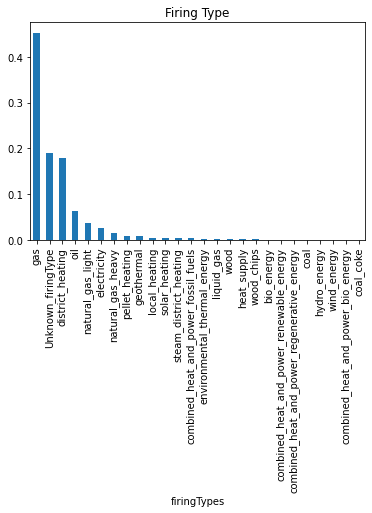

In [258]:

def clean_and_plot(df, title='Firing Type', plot=True):
    '''
    INPUT 
        df - a dataframe holding the Firing Type column
        title - string tche title of your plot
        axis - axis object
        plot - bool providing whether or not you want a plot back
        
    OUTPUT
        study_df - a dataframe with the count of how many individuals
        Displays a plot of pretty things related to the CousinEducation column.
    '''
    study = df['firingTypes'].value_counts().reset_index()
    study.rename(columns={'index': 'firingTypes', 'firingTypes': 'count'}, inplace=True)
    study_df = total_count(study, 'firingTypes', 'count', possible_vals)

    study_df.set_index('firingTypes', inplace=True)
    if plot:
        (study_df/study_df.sum()).plot(kind='bar', legend=None);
        plt.title(title);
        plt.show()
    props_study_df = study_df/study_df.sum()
    return props_study_df
    
props_df = clean_and_plot(cleaned)

### Create Dummy Variables for object columns

In [259]:
cleaned.shape

(201948, 49)

In [260]:
cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201948 entries, 0 to 268848
Data columns (total 49 columns):
 #   Column                                       Non-Null Count   Dtype           
---  ------                                       --------------   -----           
 0   regio1                                       201948 non-null  object          
 1   regio2                                       201948 non-null  object          
 2   firingTypes                                  201948 non-null  object          
 3   condition                                    150924 non-null  object          
 4   interiorQual                                 121684 non-null  object          
 5   typeOfFlat                                   175007 non-null  object          
 6   energyEfficiencyClass                        57054 non-null   object          
 7   serviceCharge                                198719 non-null  float64         
 8   totalRent                                   

In [261]:
dummy_columns = object_columns.copy()
dummy_columns.remove('firingTypes')
dummy_columns

['regio1',
 'regio2',
 'condition',
 'interiorQual',
 'typeOfFlat',
 'energyEfficiencyClass']

### Create Dummies for object columns

In [262]:
cleaned_dummy = pd.get_dummies(cleaned, columns=dummy_columns, prefix=dummy_columns, prefix_sep='_', dummy_na=True)


### Fill missing values for last refurbish
* Use year constructed column to fill last refurbish columns nan values
* Further missing values fill with zero to keep a difference and not to drop this rows.
* Missing values for year constructed fill with zero.
 

In [264]:
cleaned_dummy.lastRefurbish = cleaned_dummy.lastRefurbish.fillna(df.yearConstructed)
cleaned_dummy.lastRefurbish = cleaned_dummy.lastRefurbish.fillna(0.)
cleaned_dummy.yearConstructed = cleaned_dummy.yearConstructed.fillna(0.)


In [271]:
cleaned_dummy[float_int_columns].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201948 entries, 0 to 268848
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   serviceCharge    198719 non-null  float64
 1   totalRent        201948 non-null  float64
 2   yearConstructed  201948 non-null  float64
 3   baseRent         201948 non-null  float64
 4   livingSpace      201948 non-null  float64
 5   noRooms          201948 non-null  float64
 6   thermalChar      121715 non-null  float64
 7   floor            167017 non-null  float64
 8   heatingCosts     68263 non-null   float64
 9   lastRefurbish    201948 non-null  float64
dtypes: float64(10)
memory usage: 26.9 MB


In [272]:
cleaned_dummy = remove_outlier(cleaned_dummy[float_int_columns], columns=['noRooms'])

In [273]:
cleaned_dummy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199430 entries, 0 to 268848
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   serviceCharge    196276 non-null  float64
 1   totalRent        199430 non-null  float64
 2   yearConstructed  199430 non-null  float64
 3   baseRent         199430 non-null  float64
 4   livingSpace      199430 non-null  float64
 5   noRooms          199430 non-null  float64
 6   thermalChar      120511 non-null  float64
 7   floor            164994 non-null  float64
 8   heatingCosts     67630 non-null   float64
 9   lastRefurbish    199430 non-null  float64
dtypes: float64(10)
memory usage: 16.7 MB
